In [53]:
#Importando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

import eli5

import warnings
warnings.filterwarnings("ignore")

from sklearn.datasets import load_breast_cancer

In [2]:
#Carregando os dataset
data = pd.DataFrame(columns = load_breast_cancer()["feature_names"], data = load_breast_cancer()["data"])


In [3]:
#verificando as primeiras linhas do dataframe
data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
#verificando a quantidade de linhas e colunas
data.shape

(569, 30)

In [5]:
#Verificando se há Nan
data.isnull().sum()

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64

In [6]:
#Verificando colunas tipo object
data.dtypes

mean radius                float64
mean texture               float64
mean perimeter             float64
mean area                  float64
mean smoothness            float64
mean compactness           float64
mean concavity             float64
mean concave points        float64
mean symmetry              float64
mean fractal dimension     float64
radius error               float64
texture error              float64
perimeter error            float64
area error                 float64
smoothness error           float64
compactness error          float64
concavity error            float64
concave points error       float64
symmetry error             float64
fractal dimension error    float64
worst radius               float64
worst texture              float64
worst perimeter            float64
worst area                 float64
worst smoothness           float64
worst compactness          float64
worst concavity            float64
worst concave points       float64
worst symmetry      

In [7]:
# Separa a variável target
target = load_breast_cancer()["target"]
target = pd.DataFrame(target, columns = ['target'])

In [8]:
target.head()

,target
0,0
1,0
2,0
3,0
4,0


In [9]:
df = pd.concat([data,target], axis = 1)

In [10]:
df.shape

(569, 31)

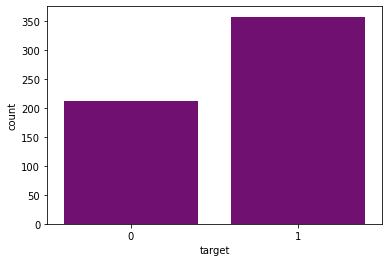

In [11]:
#Verificando o balanceamento da variável target
sns.countplot(df['target'], color= "purple")

In [12]:
corr1 = pd.concat([df.iloc[:,0:16], df['target']], axis = 1)
corr2 = df.iloc[:,16:31]

In [13]:
corr1_f = corr1.corr()
corr2_f = corr2.corr()

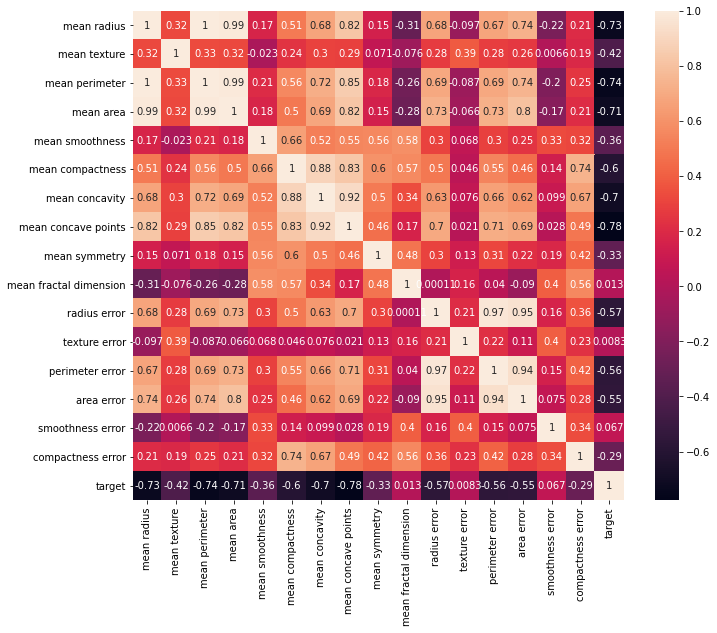

In [14]:
#Heatmap das correlações

f, ax = plt.subplots(figsize=(11, 9))
ax = sns.heatmap(corr1_f, annot= True)

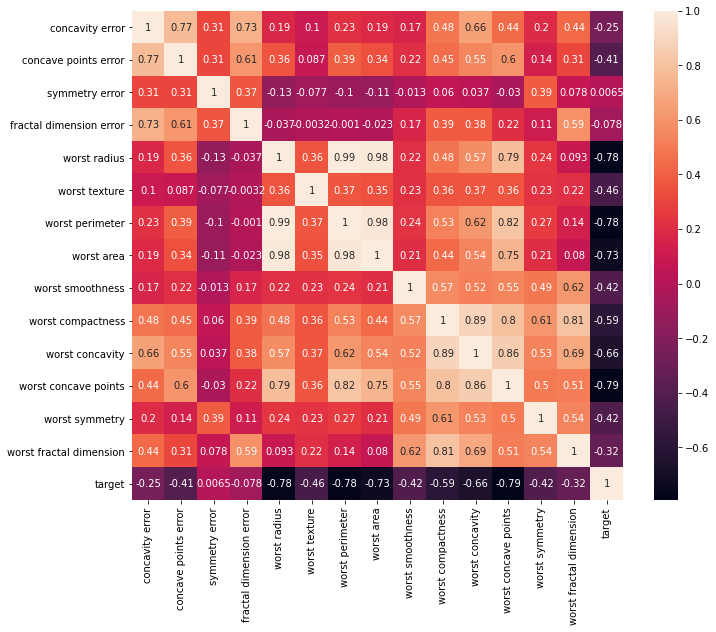

In [15]:
#Heatmap das correlações - parte 2
f, ax = plt.subplots(figsize=(11, 9))
ax = sns.heatmap(corr2_f, annot= True)

In [16]:
# Separando as variáveis em x e y
X= df.drop('target', axis=1)
y= df['target']

In [17]:
# Aplica a divisão com proporção 80/20
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.30, random_state = 121)

In [18]:
X_treino.shape, X_teste.shape, y_treino.shape, y_teste.shape 

((398, 30), (171, 30), (398,), (171,))

In [19]:
# Vamos padronizar as variáveis de entrada

# Cria o padronizador
scaler = StandardScaler()

# Treina e aplica nos dados de treino
X_treino_scaled = scaler.fit_transform(X_treino.values)

# Apenas aplica nos dados de teste
X_teste_scaled = scaler.transform(X_teste.values)

## Seleção de Variáveis - Recursive Feature Selection com Validação Cruzada

In [20]:
# Selecionando as variáveis

estimador_rfc = RandomForestClassifier(random_state = 121)

# Cria o seletor
seletor_f1 = RFECV(estimator = estimador_rfc, step = 1, cv = StratifiedKFold(10), scoring = 'f1')

# Treinamos o seletor
seletor_f1 = seletor_f1.fit(X_treino_scaled, y_treino)

In [21]:
print('Número Ideal de Atributos: {}'.format(seletor_f1.n_features_))

Número Ideal de Atributos: 18


In [22]:
# Vamos avaliar a acurácia do modelo com F1 Score
previsoes_seletor_f1 = seletor_f1.predict(X_teste_scaled)
from sklearn.metrics import accuracy_score
acc_seletor_f1 = accuracy_score(y_teste, previsoes_seletor_f1)
acc_seletor_f1

0.9707602339181286

In [23]:
# Relatório de Classificação
print(classification_report(y_teste, previsoes_seletor_f1))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        64
           1       0.99      0.96      0.98       107

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



In [24]:
# Extrai as variáveis e quais são importante ou não para o modelo
variaveis_rfecv = pd.Series(seletor_f1.support_, index = X_treino.columns)
variaveis_rfecv

mean radius                 True
mean texture                True
mean perimeter              True
mean area                   True
mean smoothness            False
mean compactness           False
mean concavity              True
mean concave points         True
mean symmetry              False
mean fractal dimension     False
radius error                True
texture error              False
perimeter error            False
area error                  True
smoothness error           False
compactness error          False
concavity error             True
concave points error       False
symmetry error             False
fractal dimension error    False
worst radius                True
worst texture               True
worst perimeter             True
worst area                  True
worst smoothness            True
worst compactness           True
worst concavity             True
worst concave points        True
worst symmetry              True
worst fractal dimension    False
dtype: boo

In [25]:
# Registra os atributos para remoção
atributos_para_remover = variaveis_rfecv[variaveis_rfecv == False].index
print(atributos_para_remover)

Index(['mean smoothness', 'mean compactness', 'mean symmetry',
       'mean fractal dimension', 'texture error', 'perimeter error',
       'smoothness error', 'compactness error', 'concave points error',
       'symmetry error', 'fractal dimension error', 'worst fractal dimension'],
      dtype='object')


In [26]:
# Cria um dataframe com os resultados
resultado_seletor_f1 = pd.DataFrame()
resultado_seletor_f1['Atributo'] = X_treino.columns[np.where(seletor_f1.support_ == True)]
resultado_seletor_f1['Score'] = seletor_f1.estimator_.feature_importances_
resultado_seletor_f1.sort_values('Score', inplace = True, ascending = True)

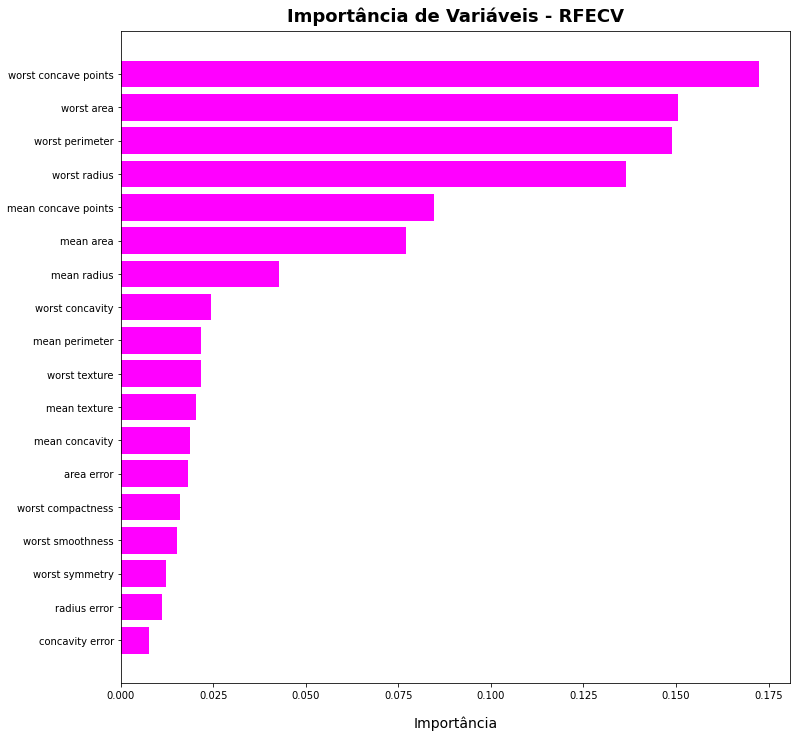

In [27]:
# Plot 
plt.figure(figsize = (12, 12))
plt.barh(y = resultado_seletor_f1['Atributo'], width = resultado_seletor_f1['Score'], color = 'Magenta')
plt.title('Importância de Variáveis - RFECV', fontsize = 18, fontweight = 'bold', pad = 10)
plt.xlabel('Importância', fontsize = 14, labelpad = 15)
plt.show()

In [28]:
X_treino_scaled = pd.DataFrame(X_treino_scaled,  columns=X_treino.columns)
X_teste_scaled = pd.DataFrame(X_teste_scaled,  columns=X_teste.columns) 

In [29]:
# Remove as variáveis menos relevantes
X_treino_scaled = X_treino_scaled.drop(atributos_para_remover, axis = 1)
X_teste_scaled = X_teste_scaled.drop(atributos_para_remover, axis = 1)

In [31]:
# Seed para reproduzir o mesmo resultado
seed = 121


# Cria o balanceador SMOTE
smote_bal = SMOTE(random_state = seed)

# Aplica o balanceador
X_res, y_res = smote_bal.fit_resample(X_treino_scaled, y_treino)

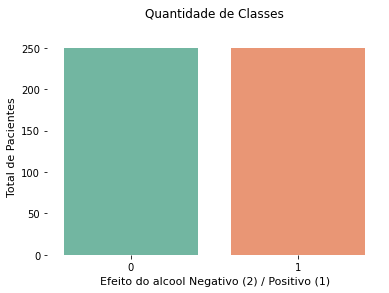

In [32]:
#Verificando o balanceamento da variável target
sns.countplot(y_res, palette="Set2")
plt.box(False)
plt.xlabel("Efeito do alcool Negativo (2) / Positivo (1)", fontsize = 11)
plt.ylabel("Total de Pacientes", fontsize = 11)
plt.title("Quantidade de Classes\n")
plt.show()

## Versão 1 - Random Forest - balanceado

In [34]:
# Cria e treina o modelo
rfc = RandomForestClassifier(criterion= 'gini',
                             max_depth= 60,
                             min_samples_leaf= 3,
                             min_samples_split= 3,
                             n_estimators= 30)
rfc.fit(X_res, y_res)

RandomForestClassifier(max_depth=60, min_samples_leaf=3, min_samples_split=3,
                       n_estimators=30)

In [35]:
# Previsões
resultado = rfc.predict(X_teste_scaled)
resultado_proba = rfc.predict_proba(X_teste_scaled)

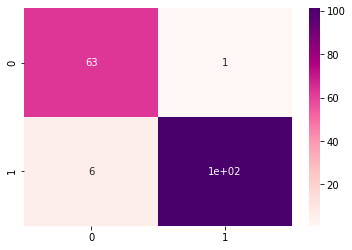

In [38]:
sns.heatmap(confusion_matrix(y_teste, resultado), annot=True, cmap="RdPu")

In [40]:
# Relatório de classificação
report = classification_report(y_teste, resultado)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.98      0.95        64
           1       0.99      0.94      0.97       107

    accuracy                           0.96       171
   macro avg       0.95      0.96      0.96       171
weighted avg       0.96      0.96      0.96       171



In [41]:
# Score AUC
print(roc_auc_score(y_teste, resultado))

0.9641501168224299


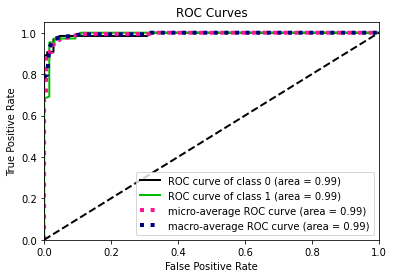

In [44]:
# Calcula a Curva ROC para cada classe

skplt.metrics.plot_roc_curve(y_teste, resultado_proba)
plt.show()

In [51]:
# Métricas Locais
recall_classe0_v1 = recall_score(y_teste, resultado, pos_label = 0)
recall_classe1_v1 = recall_score(y_teste, resultado, pos_label = 1)
precision_classe0_v1 = precision_score(y_teste, resultado, pos_label = 0)
precision_classe1_v1 = precision_score(y_teste, resultado, pos_label = 1)
print("Recall Classe 0 = {}".format(recall_classe0_v1))
print("Recall Classe 1 = {}".format(recall_classe1_v1))
print("Precision Classe 0 = {}".format(precision_classe0_v1))
print("Precision Classe 1 = {}".format(precision_classe1_v1))

# Métricas Globais
cohen_kappa_v4 = cohen_kappa_score(y_teste, resultado)
acc_v4 = rfc.score(X_teste_scaled, y_teste)
print("\nCoeficiente Cohen kappa = {}".format(cohen_kappa_v4))
print("Acurácia = {}".format(acc_v4))


Recall Classe 0 = 0.984375
Recall Classe 1 = 0.9439252336448598
Precision Classe 0 = 0.9130434782608695
Precision Classe 1 = 0.9901960784313726

Coeficiente Cohen kappa = 0.9139529868449429
Acurácia = 0.9590643274853801


## Interpretabilidade com ELI5

In [64]:
# Extrai os nomes das colunas
nomes_colunas = list(X_treino_scaled.columns)
# Interpreta os pesos dos recursos de entrada por nível de importância das variáveis
eli5.show_weights(rfc, feature_names = nomes_colunas)

Weight,Feature
0.1496 ± 0.5282,worst area
0.1419 ± 0.5406,worst radius
0.1154 ± 0.4412,area error
0.1052 ± 0.4229,worst concave points
0.0916 ± 0.4485,worst perimeter
0.0720 ± 0.4144,mean area
0.0675 ± 0.3899,mean radius
0.0523 ± 0.2409,mean concave points
0.0388 ± 0.2384,mean concavity
0.0386 ± 0.2432,mean perimeter
